In [1]:
#loading the required libraries 
#!pip install lda
import numpy as nt
import os, csv, nltk, lda
import pandas as pd
import numpy as np
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import warnings
from pandas import DataFrame, Series
import urllib.request 
import statsmodels.api as sm
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
#downloading necessary nltk corpa 
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

In [3]:
#loading the dataframe containing image labels from google image analytics 
df_zara = pd.read_excel("zara_results.xlsx")
df_hm = pd.read_excel("hm_results.xlsx")
df_hm_man = pd.read_excel("hm_man_results.xlsx")
df_zara_man = pd.read_excel("zara_man_results.xlsx")

#adding a column in each data frame identifying the brand 
df_zara['company'] = 'Zara'
df_hm['company'] = 'H&M'
df_hm_man['company'] = 'H&M_Man'
df_zara_man['company'] = 'Zara_Man'

#combining the parent brand and their men's brand dataframes 
frames_parent = [df_zara, df_hm]
frames_man = [df_zara_man,df_hm_man]

labels_parent_df = pd.concat(frames_parent)
labels_man_df = pd.concat(frames_man)

#creating a list of labels from google image analytics to store them as a list in the dataframe 
labels_parent_list = labels_parent_df['labels'].tolist()
labels_man_list = labels_man_df['labels'].tolist()

for i in range(0,len(labels_parent_list)):
    labels_parent_list[i] = str(labels_parent_list[i])
labels_parent_df['labels'] = labels_parent_list

for i in range(0,len(labels_man_df)):
    labels_man_list[i] = str(labels_man_list[i])
labels_man_df['labels'] = labels_man_list

In [4]:
#checking for nulls if present any
print("Number of rows with any of the empty columns in man's scrapped images :")
print(labels_man_df.isnull().sum().sum())
labels_man_df=labels_man_df.dropna()

print("Number of rows with any of the empty columns in parent page's scrapped images :")
print(labels_parent_df.isnull().sum().sum())
labels_parent_df=labels_parent_df.dropna()

#resetting the index for both dataframes 
labels_parent_df.reset_index(inplace = True)
labels_parent_df.drop(columns = 'index', inplace = True)
labels_man_df.reset_index(inplace = True)
labels_man_df.drop(columns = 'index', inplace = True)

Number of rows with any of the empty columns in man's scrapped images :
0
Number of rows with any of the empty columns in parent page's scrapped images :
0


In [5]:
#storing the index values in a separate variable 
index_parent = labels_parent_df.index
index_man = labels_man_df.index

In [6]:
#defining a function to perform LDA 
def lda_modeling(ntopics, df, label_column, alpha, beta, iterations):

    word_tokenizer=RegexpTokenizer(r'\w+')
    wordnet_lemmatizer = WordNetLemmatizer()
    stopwords_nltk=set(stopwords.words('english'))

    def tokenize_text(version_desc):
        lowercase=version_desc.lower()
        text = wordnet_lemmatizer.lemmatize(lowercase)
        tokens = word_tokenizer.tokenize(text)
        return tokens

    vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stopwords_nltk,decode_error='ignore')
    total_features_words = vec_words.fit_transform(df[label_column])

    model = lda.LDA(n_topics=int(ntopics), n_iter = iterations, random_state=1, alpha = alpha, eta = beta)
    model.fit(total_features_words)

    topic_word = model.topic_word_
    doc_topic = model.doc_topic_
    doc_topic = pd.DataFrame(doc_topic)
    df = df.join(doc_topic)
    df_1 = pd.DataFrame()

    for i in range(int(ntopics)):
        topic = "topic_" + str(i)
        df_1[topic] = df.groupby([df.index])[i].mean()

    df_1 = df_1.reset_index()
    topics = pd.DataFrame(topic_word)
    topics.columns = vec_words.get_feature_names()
    topics1 = topics.transpose()
    print ("Topics word distribution written in file topic_word_dist.xlsx ")
    topics1.to_excel("topic_word_dist.xlsx")
    df_1.to_excel("document_topic_dist.xlsx",index=False)
    print ("Document topic distribution written in file document_topic_dist.xlsx ")

In [7]:
lda_modeling(4, labels_parent_df, 'labels', 0.01, 0.01, 1500)

INFO:lda:n_documents: 502
INFO:lda:vocab_size: 510
INFO:lda:n_words: 6114
INFO:lda:n_topics: 4
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -50686
INFO:lda:<10> log likelihood: -35332
INFO:lda:<20> log likelihood: -34303
INFO:lda:<30> log likelihood: -33798
INFO:lda:<40> log likelihood: -33468
INFO:lda:<50> log likelihood: -33261
INFO:lda:<60> log likelihood: -33193
INFO:lda:<70> log likelihood: -33094
INFO:lda:<80> log likelihood: -33022
INFO:lda:<90> log likelihood: -33012
INFO:lda:<100> log likelihood: -32998
INFO:lda:<110> log likelihood: -32925
INFO:lda:<120> log likelihood: -32973
INFO:lda:<130> log likelihood: -32840
INFO:lda:<140> log likelihood: -32756
INFO:lda:<150> log likelihood: -32736
INFO:lda:<160> log likelihood: -32805
INFO:lda:<170> log likelihood: -32767
INFO:lda:<180> log likelihood: -32756
INFO:lda:<190> log likelihood: -32559
INFO:lda:<200> log likelihood: -32544
INFO:lda:<210> log likelihood: -32500
INFO:lda:<220> log likelihood: -32517
INFO:lda:<230> log l

Topics word distribution written in file topic_word_dist.xlsx 
Document topic distribution written in file document_topic_dist.xlsx 


In [8]:
df_parent_topic_to_list = pd.read_excel('topic_word_dist.xlsx')
df_parent_topic_to_list.set_index('Unnamed: 0', inplace = True)

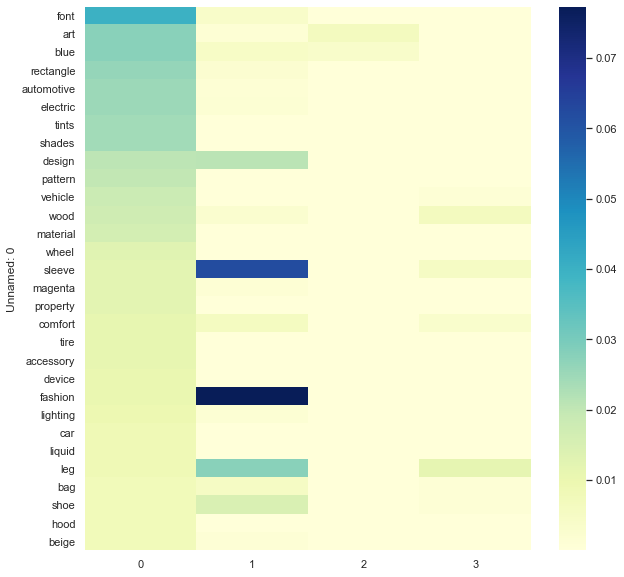

In [9]:
import seaborn as sns; sns.set_theme()
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_parent_topic_to_list.sort_values(by = 0, ascending = False)[:30], cmap = 'YlGnBu')
#abstract 

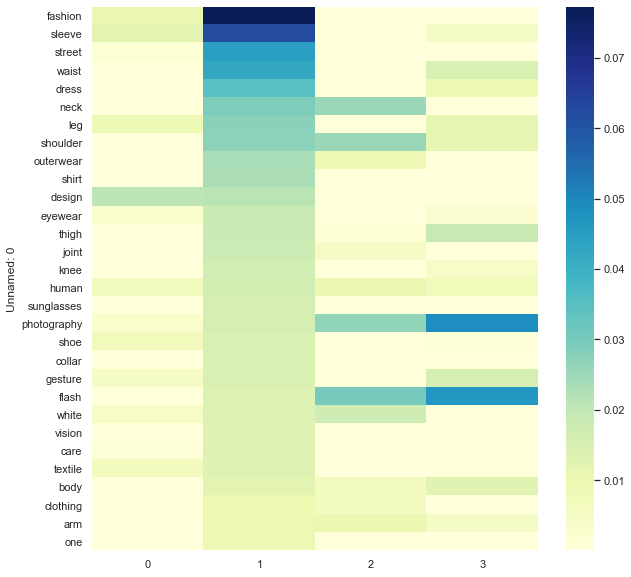

In [10]:
import seaborn as sns; sns.set_theme()
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_parent_topic_to_list.sort_values(by = 1, ascending = False)[:30], cmap = 'YlGnBu')
#sexy girl  

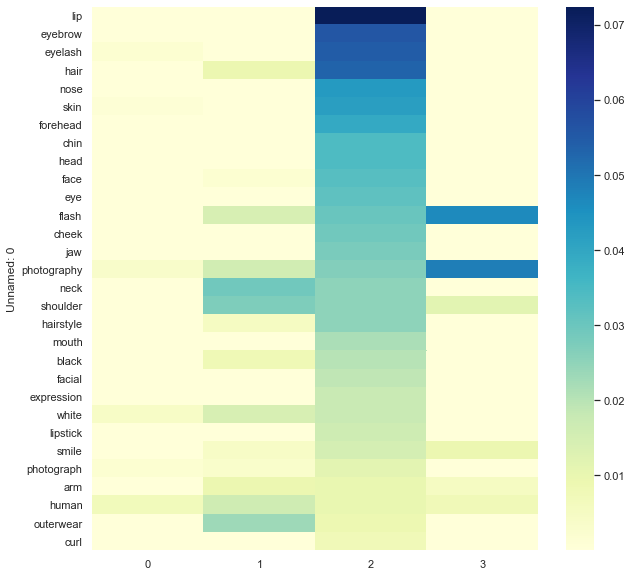

In [11]:
import seaborn as sns; sns.set_theme()
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_parent_topic_to_list.sort_values(by = 2, ascending = False)[:30], cmap = 'YlGnBu')
# facial features 

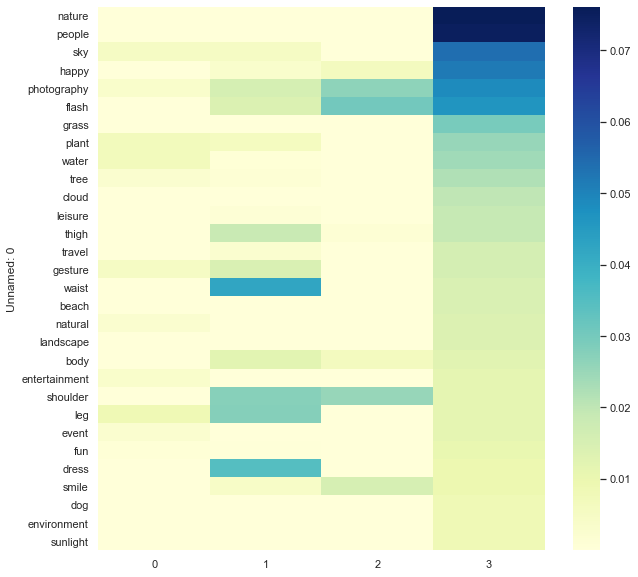

In [12]:
import seaborn as sns; sns.set_theme()
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_parent_topic_to_list.sort_values(by = 3, ascending = False)[:30], cmap = 'YlGnBu')
#outdoorsy

In [13]:
df_parent_doc_list = pd.read_excel('document_topic_dist.xlsx')
df_parent_doc_list.set_index('index', inplace = True)
df_parent_doc_list = df_parent_doc_list.rename(columns = {'topic_0' : 'abstract_misc', 'topic_1' : 'sexy', 'topic_2' : 'face', 'topic_3' : 'outdoorsy'})
df_parent_doc_list

,abstract_misc,sexy,face,outdoorsy
index,,,,
0,0.997283,0.000906,0.000906,0.000906
1,0.000831,0.000831,0.582226,0.416113
2,0.767638,0.000767,0.230828,0.000767
3,0.000767,0.997699,0.000767,0.000767
4,0.000712,0.997863,0.000712,0.000712
...,...,...,...,...
497,0.000906,0.000906,0.000906,0.997283
498,0.000831,0.997508,0.000831,0.000831
499,0.000906,0.997283,0.000906,0.000906


In [14]:
#similar stuff for man page's posts 
lda_modeling(2, labels_man_df, 'labels', 0.05, 0.9 ,1000)
df_man_topic_to_list = pd.read_excel('topic_word_dist.xlsx')
df_man_topic_to_list.set_index('Unnamed: 0', inplace = True)

INFO:lda:n_documents: 452
INFO:lda:vocab_size: 375
INFO:lda:n_words: 5556
INFO:lda:n_topics: 2
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -33091
INFO:lda:<10> log likelihood: -28310
INFO:lda:<20> log likelihood: -28082
INFO:lda:<30> log likelihood: -27855
INFO:lda:<40> log likelihood: -27743
INFO:lda:<50> log likelihood: -27714
INFO:lda:<60> log likelihood: -27650
INFO:lda:<70> log likelihood: -27632
INFO:lda:<80> log likelihood: -27426
INFO:lda:<90> log likelihood: -27369
INFO:lda:<100> log likelihood: -27368
INFO:lda:<110> log likelihood: -27354
INFO:lda:<120> log likelihood: -27360
INFO:lda:<130> log likelihood: -27288
INFO:lda:<140> log likelihood: -27317
INFO:lda:<150> log likelihood: -27342
INFO:lda:<160> log likelihood: -27310
INFO:lda:<170> log likelihood: -27313
INFO:lda:<180> log likelihood: -27305
INFO:lda:<190> log likelihood: -27324
INFO:lda:<200> log likelihood: -27362
INFO:lda:<210> log likelihood: -27241
INFO:lda:<220> log likelihood: -27284
INFO:lda:<230> log l

Topics word distribution written in file topic_word_dist.xlsx 
Document topic distribution written in file document_topic_dist.xlsx 


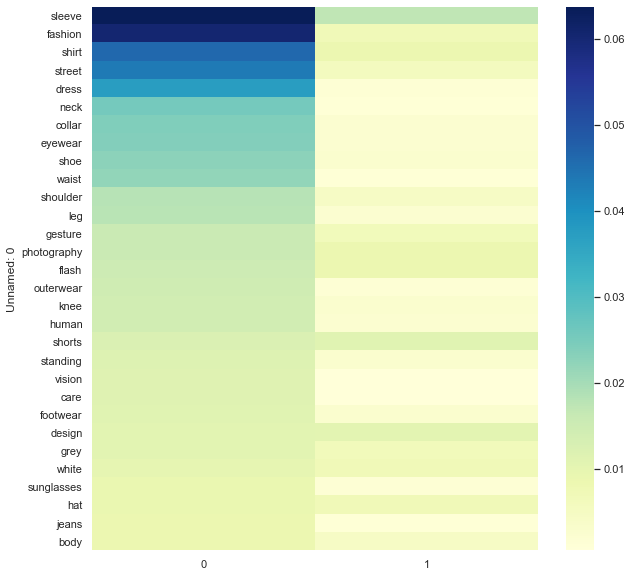

In [15]:
import seaborn as sns; sns.set_theme()
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_man_topic_to_list.sort_values(by = 0, ascending = False)[:30], cmap = 'YlGnBu')
#outdoorsy

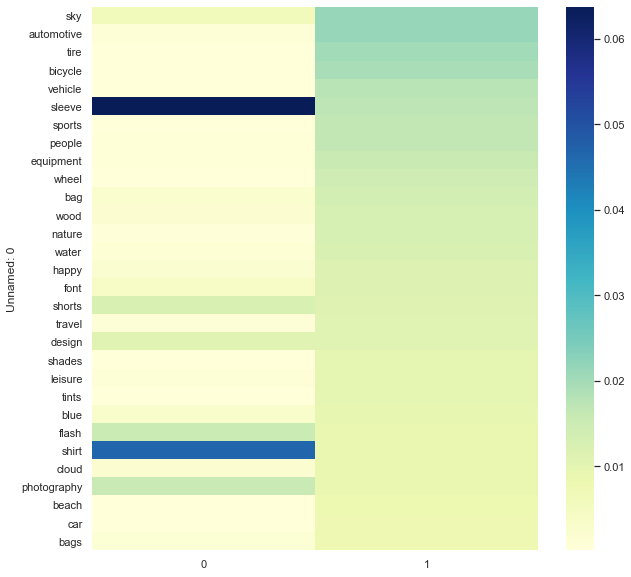

In [16]:
import seaborn as sns; sns.set_theme()
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df_man_topic_to_list.sort_values(by = 1, ascending = False)[:30], cmap = 'YlGnBu')
#fashion wear

In [17]:
df_man_doc_list = pd.read_excel('document_topic_dist.xlsx')
df_man_doc_list.set_index('index', inplace = True)
df_man_doc_list = df_man_doc_list.rename(columns = {'topic_0' : 'swag', 'topic_1' : 'athletic'})
df_man_doc_list

,swag,athletic
index,,
0,0.995495,0.004505
1,0.995868,0.004132
2,0.843511,0.156489
3,0.385496,0.614504
4,0.995050,0.004950
...,...,...
447,0.995868,0.004132
448,0.003817,0.996183
449,0.995495,0.004505


In [18]:
labels_parent_df = labels_parent_df.merge(df_parent_doc_list, left_index = True, right_index = True)
labels_parent_df

,Caption,Comments,Likes,URL,labels,company,abstract_misc,sexy,face,outdoorsy
0,The Charlotte Gainsbourg Collection for Zara. ...,230,23596,https://scontent-hou1-1.cdninstagram.com/v/t51...,"['Rectangle', 'Font', 'Technology', 'Electric ...",Zara,0.997283,0.000906,0.000906,0.000906
1,The Charlotte Gainsbourg Collection for Zara....,192,48776,https://scontent-hou1-1.cdninstagram.com/v/t51...,"['Nose', 'Hair', 'Lip', 'Outerwear', 'Eyebrow'...",Zara,0.000831,0.000831,0.582226,0.416113
2,The Charlotte Gainsbourg Collection for Zara....,124,17101,https://scontent-hou1-1.cdninstagram.com/v/t51...,"['Black-and-white', 'Font', 'Monochrome photog...",Zara,0.767638,0.000767,0.230828,0.000767
3,ZARA ATHLETICZ. Active wear that goes faster a...,456,38788,https://scontent-hou1-1.cdninstagram.com/v/t51...,"['Arm', 'Window', 'Photograph', 'Leg', 'White'...",Zara,0.000767,0.997699,0.000767,0.000767
4,"ZARA ATHLETICZ. Adaptable, multifunctional des...",165,34749,https://scontent-hou1-1.cdninstagram.com/v/t51...,"['Light', 'Automotive lighting', 'Road surface...",Zara,0.000712,0.997863,0.000712,0.000712
...,...,...,...,...,...,...,...,...,...,...
497,Stay fresh in mesh like @sintijaselicka #HM #H...,154,47547,https://scontent-hou1-1.cdninstagram.com/v/t51...,"['Sky', 'Plant', 'Azure', 'Window', 'People in...",H&M,0.000906,0.000906,0.000906,0.997283
498,A swimsuit that doubles as a statement look? S...,84,42667,https://scontent-hou1-1.cdninstagram.com/v/t51...,"['Leg', 'Waist', 'Thigh', 'Flash photography',...",H&M,0.000831,0.997508,0.000831,0.000831
499,Chill Sunday vibes: ACTIVATED. ☑️\n@chankimber...,106,38529,https://scontent-hou1-1.cdninstagram.com/v/t51...,"['Joint', 'Shorts', 'Window', 'Stomach', 'Flas...",H&M,0.000906,0.997283,0.000906,0.000906
500,Orange you glad this playsuit exists? 🧡 @ssolo...,119,43813,https://scontent-hou1-1.cdninstagram.com/v/t51...,"['Smile', 'Azure', 'Human', 'Street fashion', ...",H&M,0.000906,0.997283,0.000906,0.000906


In [19]:
labels_man_df = labels_man_df.merge(df_man_doc_list, left_index = True, right_index = True)
labels_man_df

,Caption,Comments,Likes,URL,labels,company,swag,athletic
0,ZARA ATHLETICZ. Active wear that goes faster a...,11,2526,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"['Footwear', 'Joint', 'Shorts', 'Shoe', 'Shoul...",Zara_Man,0.995495,0.004505
1,"ZARA ATHLETICZ. Adaptable, multifunctional des...",8,2782,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"['Hairstyle', 'Sleeve', 'Street fashion', 'Ges...",Zara_Man,0.995868,0.004132
2,ZARA ATHLETICZ is built on three fundamental i...,13,4816,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"['Arm', 'Shoulder', 'Shorts', 'Active shorts',...",Zara_Man,0.843511,0.156489
3,"ZARA ATHLETICZ. Adaptable, multifunctional des...",11,4888,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"['Window', 'Comfort', 'Standing', 'Black-and-w...",Zara_Man,0.385496,0.614504
4,ZARA ATHLETICZ. Active wear that goes faster a...,16,35655,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"['Footwear', 'Shorts', 'Sky', 'Shoe', 'Buildin...",Zara_Man,0.995050,0.004950
...,...,...,...,...,...,...,...,...
447,Resort shirts. Made from linen. Like what you ...,24,6419,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"['Face', 'Footwear', 'Joint', 'Shoe', 'Shoulde...",H&M_Man,0.995868,0.004132
448,It’s time to get into the summer groove. #HMMa...,25,10729,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"['Sleeve', 'Automotive design', 'Bag', 'Linens...",H&M_Man,0.003817,0.996183
449,Wavy prints and well-dressed beach vibes with ...,25,12663,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"['Head', 'Arm', 'Sky', 'Leg', 'Eyewear', 'Huma...",H&M_Man,0.995495,0.004505
450,Layers that’ll take you from day to night in a...,16,7658,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"['Shoulder', 'Arm', 'Plant', 'Street fashion',...",H&M_Man,0.995868,0.004132


In [20]:
# #to be deleted 
# a = labels_man_df.merge(df_man_doc_list, left_index = True, right_index = True)
# a.to_excel('trial.xlsx')

In [21]:
#normalizing the comments and likes 
labels_parent_df.loc[:,('comment_norm')] = labels_parent_df['Comments']/max(labels_parent_df['Comments']) 
labels_parent_df.loc[:,('likes_norm')] = labels_parent_df['Likes']/max(labels_parent_df['Likes']) 

labels_man_df.loc[:,('comment_norm')] = labels_man_df['Comments']/max(labels_man_df['Comments']) 
labels_man_df.loc[:,('likes_norm')] = labels_man_df['Likes']/max(labels_man_df['Likes']) 

In [22]:
#calculating the engaement scores 
labels_parent_df.loc[:,('engage_scores')] = ((0.4 * labels_parent_df.loc[:,('likes_norm')]) + 
                                 (0.6 * labels_parent_df.loc[:,('comment_norm')]))


labels_man_df.loc[:,('engage_scores')] = ((0.4 * labels_man_df.loc[:,('likes_norm')]) + 
                                 (0.6 * labels_man_df.loc[:,('comment_norm')]))

In [23]:
#calculating quartiles based on engagement scores - for parent pages 
q1_parent = np.percentile(labels_parent_df.engage_scores, 25)
q2_parent = np.percentile(labels_parent_df.engage_scores, 50)
q3_parent = np.percentile(labels_parent_df.engage_scores, 75)
top_quartile_parent = labels_parent_df[labels_parent_df['engage_scores'] > q3_parent]
top_quartile_parent.sort_values(by ='engage_scores', ascending = False).head()
top_quartile_average_weights_parent = top_quartile_parent[["abstract_misc",'sexy',"face",'outdoorsy']].mean(axis=0)
top_quartile_average_weights_parent

abstract_misc    0.138484
sexy             0.594022
face             0.102303
outdoorsy        0.165192
dtype: float64

In [24]:
#calculating quartiles based on engagement scores - for man pages 
q1_man = np.percentile(labels_man_df.engage_scores, 25)
q2_man = np.percentile(labels_man_df.engage_scores, 50)
q3_man = np.percentile(labels_man_df.engage_scores, 75)
top_quartile_man = labels_man_df[labels_man_df['engage_scores'] > q3_man]
top_quartile_man.sort_values(by ='engage_scores', ascending = False).head()
top_quartile_average_weights_man = top_quartile_man[["swag",'athletic']].mean(axis=0)
top_quartile_average_weights_man

swag        0.792295
athletic    0.207705
dtype: float64

In [25]:
## Logistic regression on engagement and image features
# Assign target values as 1 and 0 
center_parent = labels_parent_df['engage_scores'].median()
center_man = labels_man_df['engage_scores'].median()

#target variable
labels_parent_df['engagement_metr'] = np.where(labels_parent_df['engage_scores'] >= center_parent, 1, 0)
labels_man_df['engagement_metr'] = np.where(labels_man_df['engage_scores'] >= center_man, 1, 0)

In [26]:
#performing regression on parent pages
import pandas as pd
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(labels_parent_df['labels'].tolist())
q = vectorizer.get_feature_names()
l = pd.DataFrame(X.toarray())
for i in range(len(q)):
    l = l.rename(columns={i: q[i]}) 

l['engagement_metr'] = labels_parent_df['engagement_metr']


X_train, X_test, y_train, y_test = train_test_split(l.iloc[:,:-1], l['engagement_metr'], test_size=0.20, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train,y_train)
print("Accuracy with Image Labels: " + str(clf.score(X_test, y_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))

Accuracy with Image Labels: 0.6039603960396039
Confusion Matrix:
[[30 25]
 [15 31]]


In [27]:
len(l.columns)

l

from sklearn.decomposition import PCA

n_components = min((len(l), len(l.columns)))

X = l.iloc[:,:-1]

Y = l.iloc[:,-1]

pca = PCA(n_components)

Principal_components = pca.fit_transform(l.iloc[:,:-1])

pca_df = pd.DataFrame(data = Principal_components)

pca_df

Y

0      0
1      1
2      0
3      0
4      0
      ..
497    1
498    0
499    0
500    0
501    0
Name: engagement_metr, Length: 502, dtype: int64

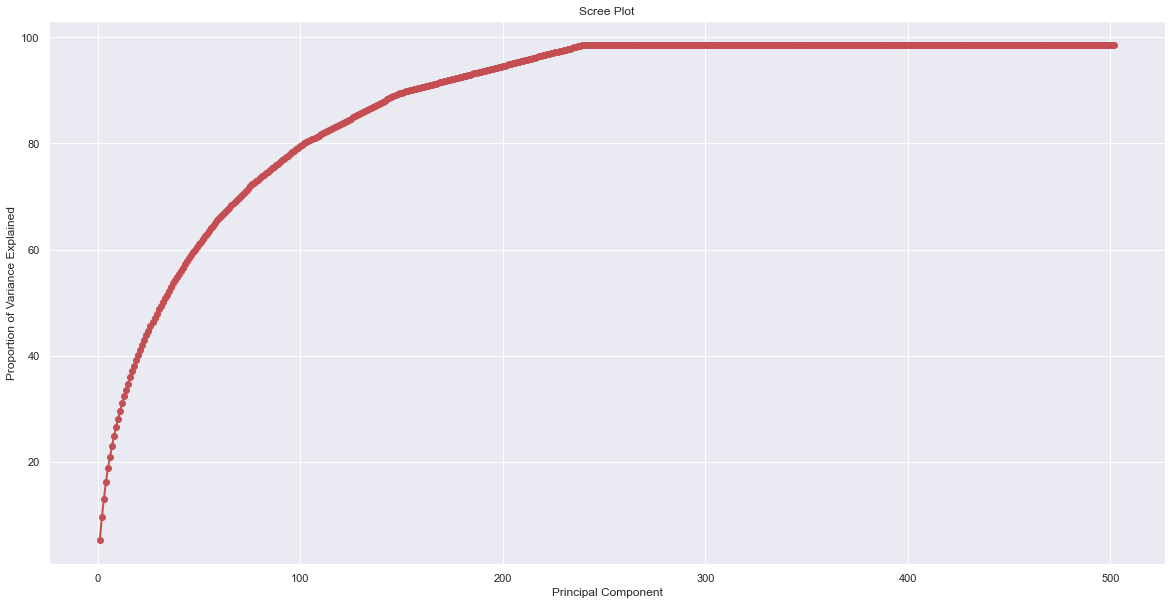

In [28]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 10))

PC_values = np.arange(pca.n_components_) + 1

plt.plot(PC_values, np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 3)*100), 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [29]:
# n_components = min((len(l), len(l.columns)))

X = l.iloc[:,:-1]

Y = l.iloc[:,-1]

pca = PCA(n_components = 250)

Principal_components = pca.fit_transform(l.iloc[:,:-1])

pca_df = pd.DataFrame(data = Principal_components)

pca_df['Y'] = Y

pca_df

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,Y
0,0.139461,0.132235,-0.291731,-0.046033,0.122143,0.101749,0.071159,0.020065,-0.140807,-0.147958,...,0.037941,-0.042210,0.048648,-0.014786,0.028210,0.011863,0.013224,-0.044720,-0.014961,0
1,0.334457,-0.120143,0.105384,-0.007488,-0.055927,-0.131485,-0.016874,0.194110,-0.008602,0.027918,...,0.030058,-0.005524,-0.007944,0.021128,0.011464,0.026134,0.029284,0.001743,-0.016042,1
2,0.140667,0.093168,-0.210161,-0.028698,0.182508,0.012416,-0.080903,0.176411,0.144733,-0.070179,...,0.030703,0.013822,-0.030394,-0.015515,0.013325,0.016184,-0.040803,0.010972,0.006405,0
3,0.066731,0.036966,0.111554,-0.027371,0.396816,-0.164891,-0.301537,0.261982,0.361330,-0.086066,...,0.025277,0.004812,-0.000874,0.005386,0.009237,-0.010954,0.006008,-0.015706,0.016086,0
4,0.089015,0.053512,-0.140890,0.023747,0.194061,-0.035914,-0.084990,0.115237,0.281085,0.034529,...,-0.001522,0.038816,0.016780,0.013431,0.058244,-0.030119,-0.000588,0.029389,0.042536,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.091164,0.429528,0.139720,0.138557,-0.237517,0.021796,-0.011631,-0.106612,0.032171,-0.024070,...,0.022849,0.111740,-0.028693,-0.069754,-0.034367,0.021027,0.022132,-0.034255,0.008246,1
498,0.016757,0.050939,0.129179,0.066943,0.241892,-0.117145,0.043394,0.190399,0.061259,0.164374,...,-0.008745,-0.003619,-0.008326,0.027544,-0.014439,-0.001044,0.033682,0.005456,-0.043275,0
499,-0.123291,0.049719,0.173309,-0.048705,0.175626,-0.225141,0.182398,0.038829,0.032759,0.108899,...,0.005095,0.003598,-0.013211,-0.048934,0.004906,-0.022571,0.001801,0.006681,0.014893,0
500,-0.215715,-0.031529,0.019887,-0.013384,-0.017491,-0.269316,0.141639,-0.085660,0.059749,-0.039018,...,-0.008003,-0.014449,-0.015738,-0.007695,-0.000200,-0.001747,-0.010532,0.023444,0.004135,0


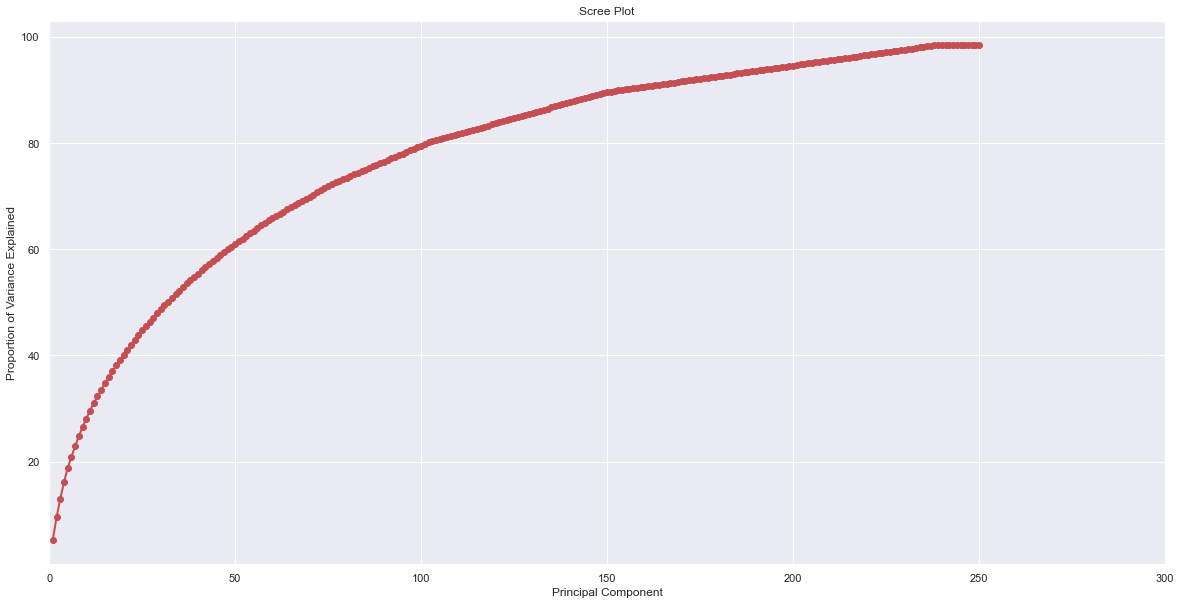

In [30]:
figure(figsize=(20, 10))

PC_values = np.arange(pca.n_components_) + 1

plt.plot(PC_values, np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 3)*100), 'ro-', linewidth=2)
plt.xlim(0,300)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [31]:

l = pca_df

l


X_train, X_test, y_train, y_test = train_test_split(l.iloc[:,:-1], l['Y'], test_size=0.20, random_state=42)

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train,y_train )
print("Accuracy with Caption Labels: " + str(clf.score(X_test, y_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))


Accuracy with Caption Labels: 0.6039603960396039
Confusion Matrix:
[[30 25]
 [15 31]]


In [32]:
l = pca_df

l


,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,Y
0,0.139461,0.132235,-0.291731,-0.046033,0.122143,0.101749,0.071159,0.020065,-0.140807,-0.147958,...,0.037941,-0.042210,0.048648,-0.014786,0.028210,0.011863,0.013224,-0.044720,-0.014961,0
1,0.334457,-0.120143,0.105384,-0.007488,-0.055927,-0.131485,-0.016874,0.194110,-0.008602,0.027918,...,0.030058,-0.005524,-0.007944,0.021128,0.011464,0.026134,0.029284,0.001743,-0.016042,1
2,0.140667,0.093168,-0.210161,-0.028698,0.182508,0.012416,-0.080903,0.176411,0.144733,-0.070179,...,0.030703,0.013822,-0.030394,-0.015515,0.013325,0.016184,-0.040803,0.010972,0.006405,0
3,0.066731,0.036966,0.111554,-0.027371,0.396816,-0.164891,-0.301537,0.261982,0.361330,-0.086066,...,0.025277,0.004812,-0.000874,0.005386,0.009237,-0.010954,0.006008,-0.015706,0.016086,0
4,0.089015,0.053512,-0.140890,0.023747,0.194061,-0.035914,-0.084990,0.115237,0.281085,0.034529,...,-0.001522,0.038816,0.016780,0.013431,0.058244,-0.030119,-0.000588,0.029389,0.042536,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.091164,0.429528,0.139720,0.138557,-0.237517,0.021796,-0.011631,-0.106612,0.032171,-0.024070,...,0.022849,0.111740,-0.028693,-0.069754,-0.034367,0.021027,0.022132,-0.034255,0.008246,1
498,0.016757,0.050939,0.129179,0.066943,0.241892,-0.117145,0.043394,0.190399,0.061259,0.164374,...,-0.008745,-0.003619,-0.008326,0.027544,-0.014439,-0.001044,0.033682,0.005456,-0.043275,0
499,-0.123291,0.049719,0.173309,-0.048705,0.175626,-0.225141,0.182398,0.038829,0.032759,0.108899,...,0.005095,0.003598,-0.013211,-0.048934,0.004906,-0.022571,0.001801,0.006681,0.014893,0
500,-0.215715,-0.031529,0.019887,-0.013384,-0.017491,-0.269316,0.141639,-0.085660,0.059749,-0.039018,...,-0.008003,-0.014449,-0.015738,-0.007695,-0.000200,-0.001747,-0.010532,0.023444,0.004135,0


In [33]:
# Keeping all captions intact and using tf-idf score
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(labels_parent_df['Caption'].tolist())
q = vectorizer.get_feature_names()
l = pd.DataFrame(X.toarray())
for i in range(len(q)):
    l = l.rename(columns={i: q[i]}) 

l['engagementVal'] = labels_parent_df['engagement_metr']

X_train, X_test, y_train, y_test = train_test_split(l.iloc[:,:-1], l['engagementVal'], test_size=0.15, random_state=42)

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train,y_train )
print("Accuracy with Caption Labels: " + str(clf.score(X_test, y_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))

l

Accuracy with Caption Labels: 0.631578947368421
Confusion Matrix:
[[23 17]
 [11 25]]


,001,002,003,004782002,009840003,01,02,0273140034,0274984001,03,...,zarapets,zarasrpls,zarastudio,zarawoman,zip,zircons,zoeghertner,zoesiskos,𝓮𝓵𝓮𝓰𝓪𝓷𝓬𝓮,engagementVal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [40]:
word_tokenizer=RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_nltk=set(stopwords.words('english'))


def tokenize_text(version_desc):
        lowercase=version_desc.lower()
        text = wordnet_lemmatizer.lemmatize(lowercase)
        tokens = word_tokenizer.tokenize(text)
        return tokens

def list_to_string(s):
    str1 = " "
    return (str1.join(s))

    
labels_parent_df['caption+label'] = labels_parent_df['Caption'] + " " + labels_parent_df['labels'].apply(tokenize_text).replace("'","").apply(list_to_string).apply(lambda x: x.lower())

# Keeping all captions intact and using tf-idf score
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(labels_parent_df['caption+label'].tolist())
q = vectorizer.get_feature_names()
l = pd.DataFrame(X.toarray())
for i in range(len(q)):
    l = l.rename(columns={i: q[i]}) 

l['engagementVal'] = labels_parent_df['engagement_metr']

X_train, X_test, y_train, y_test = train_test_split(l.iloc[:,:-1], l['engagementVal'], test_size=0.20, random_state=42)

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train,y_train )
print("Accuracy with Caption Labels: " + str(clf.score(X_test, y_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))

Accuracy with Caption Labels: 0.6732673267326733
Confusion Matrix:
[[30 25]
 [ 8 38]]


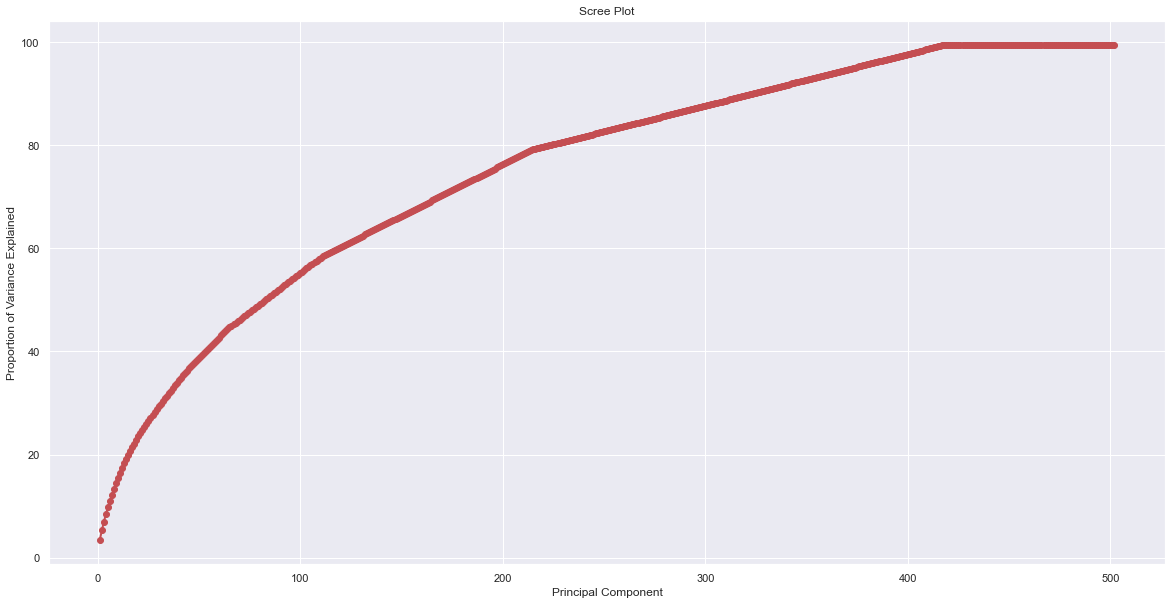

,001,002,003,004782002,009840003,01,02,0273140034,0274984001,03,...,zarasrpls,zarastudio,zarawoman,zebra,zip,zircons,zoeghertner,zoesiskos,𝓮𝓵𝓮𝓰𝓪𝓷𝓬𝓮,engagementVal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.248348,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0


In [43]:
# len(l.columns)

n_components = min((len(l), len(l.columns)))

X = l.iloc[:,:-1]

Y = l.iloc[:,-1]

pca = PCA(n_components)

Principal_components = pca.fit_transform(l.iloc[:,:-1])

pca_df = pd.DataFrame(data = Principal_components)

pca_df['Y'] = Y

pca_df

figure(figsize=(20, 10))

PC_values = np.arange(pca.n_components_) + 1

plt.plot(PC_values, np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 3)*100), 'ro-', linewidth=2)
# plt.xlim(0,300)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

l


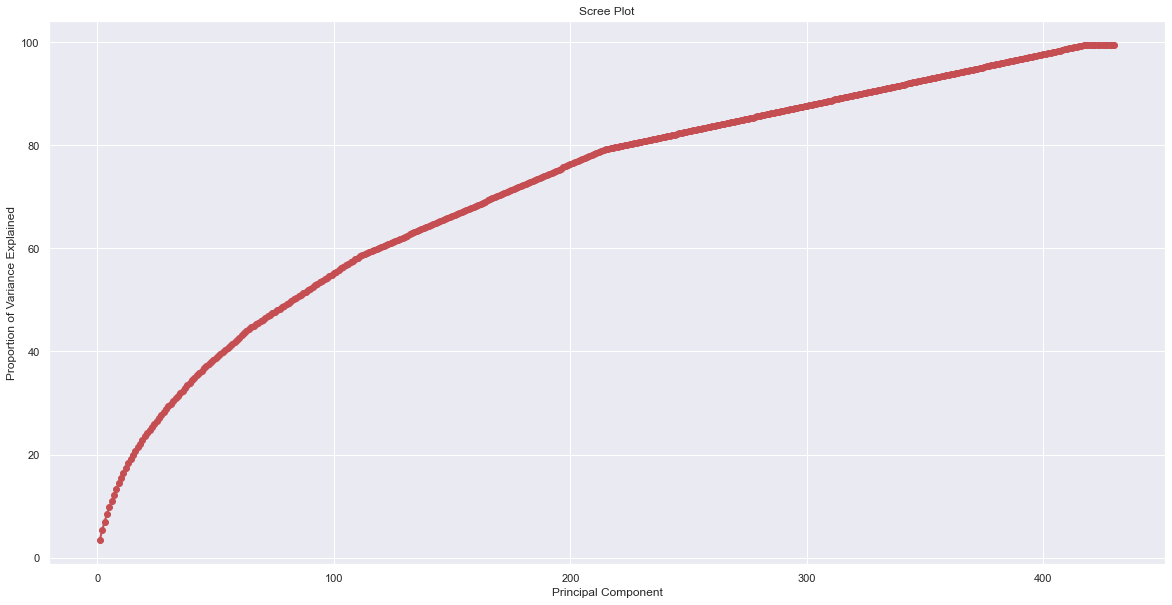

Accuracy with Caption Labels: 0.6732673267326733
Confusion Matrix:
[[30 25]
 [ 8 38]]


In [44]:
X = l.iloc[:,:-1]

Y = l.iloc[:,-1]

pca = PCA(n_components = 430)

Principal_components = pca.fit_transform(l.iloc[:,:-1])

pca_df = pd.DataFrame(data = Principal_components)

pca_df['Y'] = Y

pca_df

figure(figsize=(20, 10))

PC_values = np.arange(pca.n_components_) + 1

plt.plot(PC_values, np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 3)*100), 'ro-', linewidth=2)
# plt.xlim(0,300)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()


l = pca_df



X_train, X_test, y_train, y_test = train_test_split(l.iloc[:,:-1], l['Y'], test_size=0.20, random_state=42)

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train,y_train )
print("Accuracy with Caption Labels: " + str(clf.score(X_test, y_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))




In [ ]:
labels_parent_df.to_excel("parent_page_final.xlsx")

In [ ]:
labels_man_df.to_excel("man_page_final.xlsx")

In [ ]:
from sklearn.decomposition import PCA

n_components == min(n_samples, n_features)


pca = PCA(n_components=2)